# Sentiment Analysis with Machine Learning Models

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

import functions as f

In [3]:
M_bow = f.load_pickle('data/M_bow_100k.pickle')
M_tfidf = f.load_pickle('data/M_tfidf_100k.pickle')
M_svd = f.load_pickle('data/M_svd_100k.pickle')
M_nmf = f.load_pickle('data/M_nmf_100k.pickle')
M_word2vec = f.load_pickle('data/M_word2vec_100k.pickle')
y = f.load_pickle('data/sentiment_100k.pickle')

## Machine Learning Models Comparison

There is no one answer which combination of text representation and machine learning model will perform best. In order to find the optimal solution, each configuration needs to be tested. There are 5 different text representations: bag of words, TF-IDF, co-occurrence matrix with SVD and NMF decomposition and word2vec. They will be used in the following predictive models:
- Multinomial Naive Bayes
- SGD classifier
- Logistic Regression

In order to evaluate model performance, cross validation is implemented, measuring: test accuracy, f1 score, precision and recall. In the first place, model will be assessed by accuracy and f1 score. At the same time, it's important to note that there is high class imbalance in the dataset - the majority of reviews is positive. Due to this fact, it's enough to label all reviews as positive to reach 91,5% accuracy. Because of that, accuracy is not a sufficient metric and it's also valuable to look at precision and recall.

Since Naive Bayes takes only positive values as input, SVD and Word2Vec embeddings were transformed with MinMaxScaler.

In [4]:
baseline = sum(y)/len(y)
print('Baseline accuracy: ', baseline)

Baseline accuracy:  0.9148


In [5]:
scaler = MinMaxScaler()
M_svd_positive = scaler.fit_transform(M_svd)
M_word2vec_positive = scaler.fit_transform(M_word2vec)

In [6]:
embeddings_names = ['BOW', 'TFIDF', 'SVD', 'NMF', 'Word2Vec']
embeddings = [M_bow, M_tfidf, M_svd, M_nmf, M_word2vec]
embeddings_positive = [M_bow, M_tfidf, M_svd_positive, M_nmf, M_word2vec_positive]
results_names = ['test_acc', 'f1', 'precision', 'recall']

### Multinomial Naive Bayes

Naive Bayes Classifier is a simple model that’s usually used in a wide variety of classification tasks (both binary and multiclass). The name "naive" comes from the fact that it assumes the features that go into the model are independent of each other. It provides a way to calculate the probability of a piece of data belonging to a given class, given our prior knowledge.

It performs best with BOW word vectors (the highest test accuracy and f1 score). Naive Bayes used with SVD and Word2Vec model return the baseline accuracy and recall equal to 1 which means that it assigned all reviews to the "positive" class.

In [7]:
naive = MultinomialNB()

naive_cv = f.model_cv(naive, embeddings_positive, y)
f.df_model_cv(naive_cv, embeddings_names, results_names)

test_acc        f1  precision    recall
BOW        0.94656  0.970859   0.968570  0.973164
TFIDF      0.93515  0.965680   0.935993  0.997311
SVD        0.91480  0.955504   0.914800  1.000000
NMF        0.72811  0.841202   0.903112  0.787243
Word2Vec   0.91480  0.955504   0.914800  1.000000

### SGD Classifier

SGD Classifier implements regularized linear models with stochastic gradient descent learning. In the first example it fits SVM model, and in the second logistic regression.

An SVM model is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible.
Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.

Both SGD Classifiers return similar results. The best solution is achieved with BOW word vectors and SVD model.

In [13]:
sgd = SGDClassifier(random_state=9, n_jobs=-1)

sgd_cv = f.model_cv(sgd, embeddings, y)
f.df_model_cv(sgd_cv, embeddings_names, results_names)

test_acc        f1  precision    recall
BOW        0.95621  0.976397   0.963097  0.990074
TFIDF      0.94960  0.973100   0.950783  0.996491
SVD        0.85770  0.921848   0.925756  0.918135
NMF        0.91480  0.955504   0.914800  1.000000
Word2Vec   0.94956  0.972803   0.960062  0.985931

In [14]:
sgd_log = SGDClassifier(loss='log', penalty='elasticnet', random_state=9, n_jobs=-1)

sgd_log_cv = f.model_cv(sgd_log, embeddings, y)
f.df_model_cv(sgd_log_cv, embeddings_names, results_names)

test_acc        f1  precision    recall
BOW        0.95324  0.974855   0.959370  0.990850
TFIDF      0.94032  0.968344   0.940585  0.997792
SVD        0.84823  0.915755   0.928278  0.904143
NMF        0.91480  0.955504   0.914800  1.000000
Word2Vec   0.94950  0.972703   0.962119  0.983548

### Logistic Regression

Logistic regression, despite its name, is a linear model for classification rather than regression. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

It returns the best results for TF-IDF word vectors. It is also the best result achieved so far. Logistic Regression with SVD and NMF word vectors assigned all observations to the "positive" class (recall = 1).

In [7]:
logreg = LogisticRegression(max_iter=500, random_state=9, n_jobs=-1)

logreg_cv = f.model_cv(logreg, embeddings, y)
f.df_model_cv(logreg_cv, embeddings_names, results_names)

test_acc        f1  precision    recall
BOW        0.95678  0.976600   0.967468  0.985909
TFIDF      0.95808  0.977440   0.962655  0.992687
SVD        0.91480  0.955504   0.914800  1.000000
NMF        0.91480  0.955504   0.914800  1.000000
Word2Vec   0.95048  0.973322   0.959593  0.987451

## Verification of model performance

Logistic Regression with TF-IDF word vectors resulted in 95,8% accuracy and 0.9774 f1-score. It's the best result achieved so far.

Let's analyze results of this particular model:
- try to predict sentiment of two example reviews
- analyze errors (true positiives, false positives etc)
- browse reviews that were assigned to incorrect class

In [8]:
vectorizer = f.load_pickle('data/tfidf_vectorizer_100k.pickle')
df = pd.read_csv('data/reviews_toys_games_100k.csv')

X_train, X_test, y_train, y_test = train_test_split(M_tfidf, np.array(y), test_size=0.33, random_state=9)

In [9]:
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=500, n_jobs=-1, random_state=9)

In [10]:
review_test_pos = 'This game is amazing ^^, my son plays with it all the time!'
review_test_neg = 'I\'m really disappointed with this game. My son doesn\'t like playing with it.'

In [11]:
review_tokens_test_pos = f.normalize_single_text(review_test_pos)
tfidf_vector_test_pos = vectorizer.transform([' '.join(review_tokens_test_pos)])
logreg.predict(tfidf_vector_test_pos)

array([1])

In [12]:
review_tokens_test_neg = f.normalize_single_text(review_test_neg)
tfidf_vector_test_neg = vectorizer.transform([' '.join(review_tokens_test_neg)])
logreg.predict(tfidf_vector_test_neg)

array([0])

### Confusion matrix of reviews' sentiment

In [13]:
y_pred = logreg.predict(X_test)

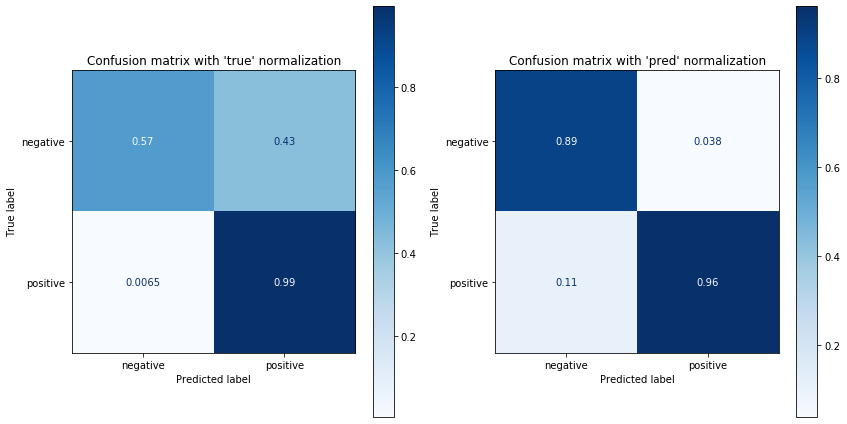

In [75]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
confusion_dict = {ax1: 'true', ax2: 'pred'}

for k, v in confusion_dict.items():
    plot_confusion_matrix(logreg, X_test, y_test,
                          cmap=plt.cm.Blues,
                          display_labels=['negative', 'positive'],
                          normalize=v, ax=k)
    k.set_title('Confusion matrix with \'%s\' normalization' % v)
plt.tight_layout()
plt.show()

The model is very good at finding positive reviews - from all positive reviews, over 99% were assigned correct label. When it comes to negative reviews, the model assign correct label only in 57% of cases.

When we look at the predicted labels, from all positive labels, 96% are true positives and,3,8% are false positives. Among labels predicted as negative, 89% are true negatives and 11% are false negatives.

In [20]:
y_diff = y_test - y_pred
np.where(y_diff != 0)[0][:40]

array([ 66,  69,  83, 103, 119, 150, 165, 174, 178, 194, 215, 306, 314,
       321, 328, 337, 351, 362, 387, 396, 405, 412, 492, 549, 568, 575,
       629, 641, 661, 700, 782, 795, 803, 813, 854, 855, 858, 879, 886,
       922], dtype=int64)

In [24]:
i = 69
print(df['review'][i])
print('\nreal label:', y_test[i], '\npredicted label:', y_pred[i])

Son really loves it.

real label: 0 
predicted label: 1


In this example, we can see that the real label was incorrect, since the review is obviously positive. In this case, the model was right when assigning positive label.

In [23]:
i = 119
print(df['review'][i])
print('\nreal label:', y_test[i], '\npredicted label:', y_pred[i])

cheap plastic, broken when arrived in manilla envelope

real label: 0 
predicted label: 1


This review is clearly negative and the model made a mistake. It's interesting why this review was marked as positive, since it contains words like 'cheap' and 'broken'.

In [77]:
i = 568
print(df['review'][i])
print('\nreal label:', y_test[i], '\npredicted label:', y_pred[i])

Looks good nephew loves it

real label: 1 
predicted label: 0


It's another interesting example - the review is clearly positive but the model assigned it as negative, despite the fact that the review contains such words as 'good' and 'loves'.

## Under- and over-sampling

Since the dataset is highly imbalanced, one of the possible solutions to this problem is to sample observations in a way that the number of items in the classes will be equal. Two approaches will be tested:
- under-sampling - removing random observations from the majority class
- over-sampling (SMOTE) - adding observations to the minority class.
- mix of SMOTE and under-sampling

In order to optimize computations, the SGD model was used instead of Logistic Regression.

According to the results of this experiment, both under-sampling and SMOTE are not effective methods to improve performance of the model - both accuracy and f1-score decreased. Poor results were achieved also with mix of SMOTE and under-sampling.

In [7]:
under_sampler_pipeline = make_pipeline(RandomUnderSampler(random_state=9),
                              SGDClassifier(random_state=9, n_jobs=-1))

under_sampler_cv = f.model_cv(under_sampler_pipeline, embeddings, y)
f.df_model_cv(under_sampler_cv, embeddings_names, results_names)

test_acc        f1  precision    recall
BOW        0.90551  0.946164   0.988042  0.907696
TFIDF      0.89178  0.937645   0.991350  0.889462
SVD        0.57232  0.683681   0.969810  0.552678
NMF        0.57762  0.693126   0.975253  0.554657
Word2Vec   0.86554  0.921010   0.989895  0.861915

In [9]:
smote_pipeline = make_pipeline(SMOTE(random_state=9, n_jobs=-1),
                              SGDClassifier(random_state=9, n_jobs=-1))

smote_cv = f.model_cv(smote_pipeline, embeddings_positive, y)
f.df_model_cv(smote_cv, embeddings_names, results_names)

test_acc        f1  precision    recall
BOW        0.90060  0.943699   0.979011  0.910866
TFIDF      0.90297  0.944651   0.987726  0.905181
SVD        0.56958  0.695626   0.983651  0.538478
NMF        0.56991  0.693327   0.981305  0.540774
Word2Vec   0.89558  0.939940   0.987893  0.896906

In [17]:
mixed_pipeline = make_pipeline(SMOTE(random_state=9, sampling_strategy=0.33, n_jobs=-1),
                 RandomUnderSampler(random_state=9, sampling_strategy=0.66),
                 SGDClassifier(random_state=9, n_jobs=-1))

mixed_cv = f.model_cv(mixed_pipeline, embeddings_positive, y)
f.df_model_cv(mixed_cv, embeddings_names, results_names)

test_acc        f1  precision    recall
BOW        0.90861  0.948303   0.982630  0.916299
TFIDF      0.91473  0.951791   0.985668  0.920168
SVD        0.68893  0.800413   0.967076  0.683428
NMF        0.70575  0.814305   0.962443  0.705969
Word2Vec   0.90032  0.942873   0.986997  0.903017